Overlay linear water features

NB- use a buffer width of 100m for water features

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, box, LineString
from shapely import intersection
from tqdm.notebook import tqdm
import glob

target_epsg = 6350  # https://epsg.org/crs_6350/NAD83-2011-Conus-Albers.html?sessionkey=nb47agmo4r

In [25]:
fn_aoi = '/Volumes/Extreme SSD/largest_plots/clean_data/aoi.parquet'
fn_water_linear_overlay = '/Volumes/Extreme SSD/largest_plots/clean_data/water_linear_overlay.parquet'
dir_water_linear = '/Volumes/Extreme SSD/largest_plots/raw_data/linear_water/*.zip'
fn_list_water_linear = glob.glob(dir_water_linear)

In [3]:
Aoi = gpd.read_parquet(fn_aoi).set_geometry('aoi').set_crs(epsg=target_epsg)

Iterate through each AOI x each water linear file.
- Keep any rows that overlap at all with the AOI
- Each AOI's results will be stored as a list of geopandas tables.

In [5]:
intersection_dict = {}
for i in Aoi.index:
    intersection_dict[i] = list()

for fn_water_linear in tqdm(fn_list_water_linear):
    WaterLinear = gpd.read_file(fn_water_linear).to_crs(epsg=target_epsg)
    
    for i in Aoi.index:
        single_aoi = Aoi.loc[[i]]
        Intersection = gpd.sjoin(WaterLinear, single_aoi, how='inner', predicate='intersects')
        if Intersection.shape[0] > 0:
            intersection_dict[i].append(Intersection)
        else:
            pass

  0%|          | 0/3233 [00:00<?, ?it/s]

For each entry in the previous dictionary:
- flatten the list of tables into one table
- flatten the geometries in this new table into one geometry file
- trim the flat geometry to the dimensions of the AOI box

In [7]:
# Did each AOI have an intersection?
len(intersection_dict.keys()) == len(Aoi)

True

Iterate through the above dictionary, actually calculating the intersection between each AOI and the relevant water linear polygons.
Buffer here.

In [14]:
overlay_dict = {}

for i in tqdm(intersection_dict.keys()):  # iterate through these indices, because in theory, an index from the AOI might not have intersected at all with the water files
    intersections_in_list = intersection_dict[i]
    water_linear_flat = pd.concat(intersections_in_list).buffer(distance=50, cap_style='round').reset_index(drop=True).unary_union

    single_aoi = Aoi.loc[[i]]
    overlay = single_aoi.intersection(water_linear_flat).to_frame().reset_index(drop=True).loc[0,0]
    overlay_dict[i] = overlay

  0%|          | 0/56 [00:00<?, ?it/s]

In [15]:
intersection_dict.keys() == overlay_dict.keys()

True

In [16]:
WaterLinearOverlay = gpd.GeoDataFrame({'index':overlay_dict.keys(), 'geometry':overlay_dict.values()}, crs='epsg:'+str(target_epsg))
WaterLinearOverlay.set_geometry('geometry', inplace=True)
WaterLinearOverlay.set_index('index', drop=True, inplace=True, verify_integrity=True)
WaterLinearOverlay.head()

,geometry
index,
0,"MULTIPOLYGON (((1064783.733 1246651.126, 10647..."
1,"MULTIPOLYGON (((1253970.757 1244846.123, 12539..."
2,"MULTIPOLYGON (((1280030.297 1416535.056, 12796..."
3,"MULTIPOLYGON (((1652992.164 1566726.050, 16529..."
4,"MULTIPOLYGON (((1517647.954 1484396.628, 15176..."


# Manual QC fun

<Axes: >

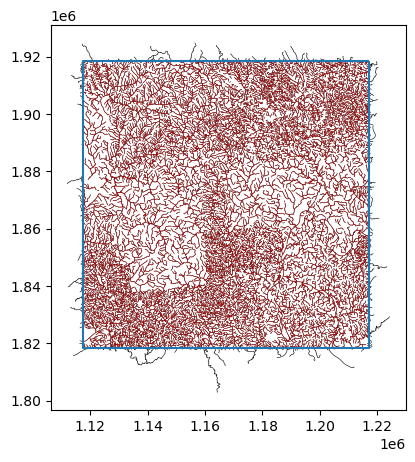

In [27]:
# Note that these are 'buffered', ie expanded, so we can see them easily here.
i = 50
fig, ax = plt.subplots(figsize=(5, 5))
Aoi.loc[[i]].boundary.plot(ax=ax)
gpd.GeoDataFrame(pd.concat(intersection_dict[i])).buffer(distance=100).plot(ax=ax, color='black')
WaterLinearOverlay.loc[[i]].buffer(distance=5).plot(ax=ax, color='red')

# Save to disk

In [26]:
WaterLinearOverlay.to_parquet(fn_water_linear_overlay)